In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.datasets import cifar10
import time

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
# Convert to float for better processing
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [4]:
# Flatten the y labels
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Use a small subset of the data for demonstration
n_train_samples = 1000  # Using 1000 training samples
n_test_samples = 200    # Using 200 testing samples

X_train_sample = X_train[:n_train_samples]
y_train_sample = y_train[:n_train_samples]
X_test_sample = X_test[:n_test_samples]
y_test_sample = y_test[:n_test_samples]

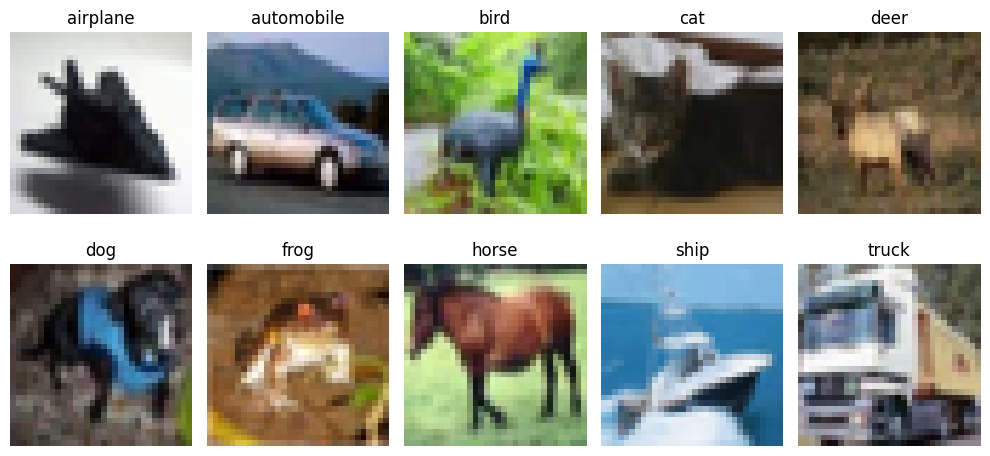

In [6]:
# Visualize some sample images
plt.figure(figsize=(10, 5))
for i in range(10):  # Show one example of each class
    plt.subplot(2, 5, i+1)
    # Find the first occurrence of class i
    idx = np.where(y_train_sample == i)[0][0]
    plt.imshow(X_train_sample[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert RGB to grayscale by averaging the channels
        gray_image = np.mean(image, axis=2)

        # Extract HOG features
        fd = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

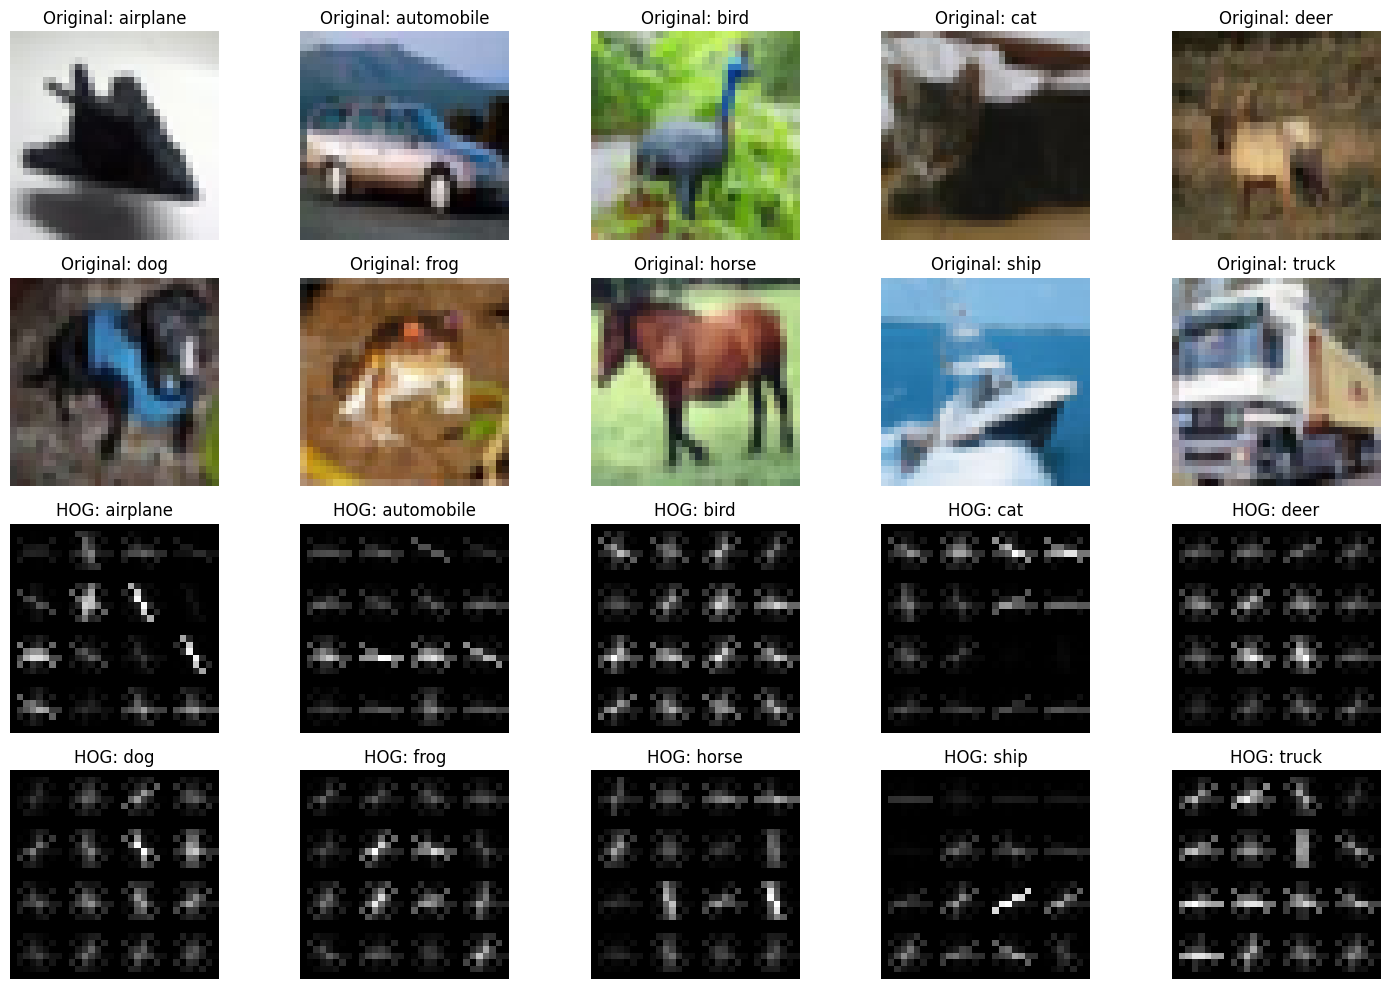

Extracting HOG features for training data...
Training HOG features extraction completed in 0.46 seconds
Shape of HOG features: (1000, 324)

Extracting HOG features for test data...
Testing HOG features extraction completed in 0.09 seconds


In [8]:
# Visualize HOG features for one example of each class
plt.figure(figsize=(15, 10))
for i in range(10):
    # Get one example of each class
    idx = np.where(y_train_sample == i)[0][0]
    img = X_train_sample[idx]
    gray_img = np.mean(img, axis=2)

    # Compute HOG features and HOG image
    fd, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True)

    # Rescale HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display original and HOG images
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(f"Original: {class_names[i]}")
    plt.axis('off')

    plt.subplot(4, 5, i+11)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title(f"HOG: {class_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Extracting HOG features for training data...")
start_time = time.time()
X_train_hog = extract_hog_features(X_train_sample)
print(f"Training HOG features extraction completed in {time.time() - start_time:.2f} seconds")
print(f"Shape of HOG features: {X_train_hog.shape}")

print("\nExtracting HOG features for test data...")
start_time = time.time()
X_test_hog = extract_hog_features(X_test_sample)
print(f"Testing HOG features extraction completed in {time.time() - start_time:.2f} seconds")

In [9]:
# Train a classifier
print("\nTraining Linear SVM classifier...")
start_time = time.time()
svm = LinearSVC(random_state=42)
svm.fit(X_train_hog, y_train_sample)
print(f"Classifier training completed in {time.time() - start_time:.2f} seconds")


Training Linear SVM classifier...
Classifier training completed in 0.64 seconds


In [10]:
# Make predictions
y_pred = svm.predict(X_test_hog)

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test_sample, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_sample, y_pred, target_names=class_names))


Accuracy: 0.3000

Classification Report:
              precision    recall  f1-score   support

    airplane       0.05      0.05      0.05        20
  automobile       0.18      0.29      0.22        14
        bird       0.33      0.33      0.33        21
         cat       0.36      0.26      0.30        19
        deer       0.50      0.47      0.48        15
         dog       0.07      0.06      0.06        18
        frog       0.29      0.38      0.33        26
       horse       0.31      0.50      0.38        18
        ship       0.35      0.21      0.27        28
       truck       0.67      0.48      0.56        21

    accuracy                           0.30       200
   macro avg       0.31      0.30      0.30       200
weighted avg       0.32      0.30      0.30       200



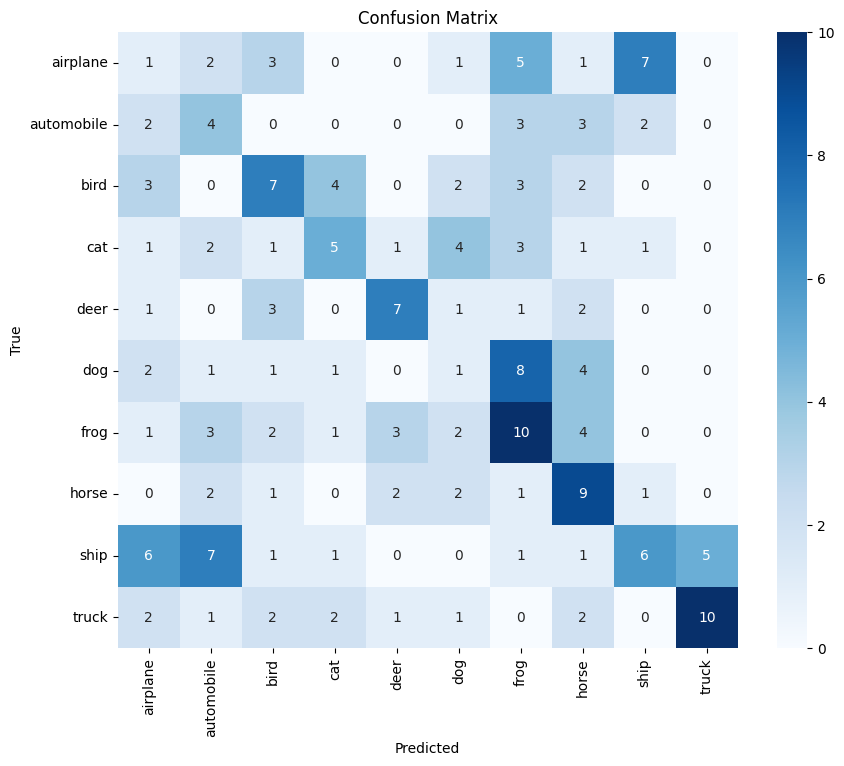

In [12]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_sample, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Visualize some correctly and incorrectly classified samples
correct = np.where(y_pred == y_test_sample)[0]
incorrect = np.where(y_pred != y_test_sample)[0]

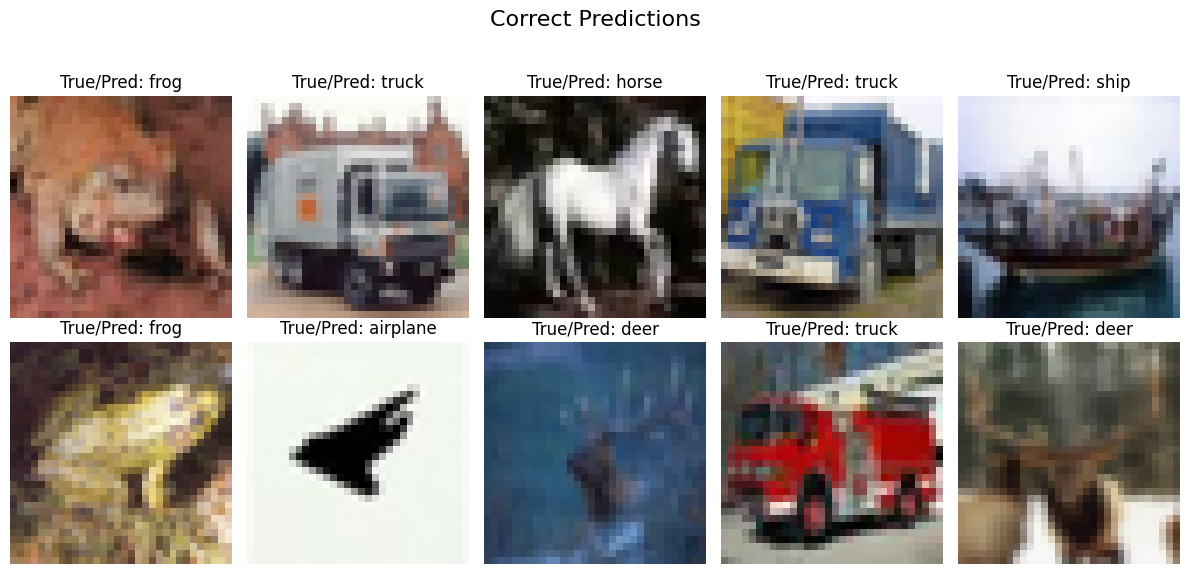

In [14]:
# Show some correct predictions
plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)
for i in range(min(10, len(correct))):
    plt.subplot(2, 5, i+1)
    idx = correct[i]
    plt.imshow(X_test_sample[idx])
    plt.title(f"True/Pred: {class_names[y_test_sample[idx]]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

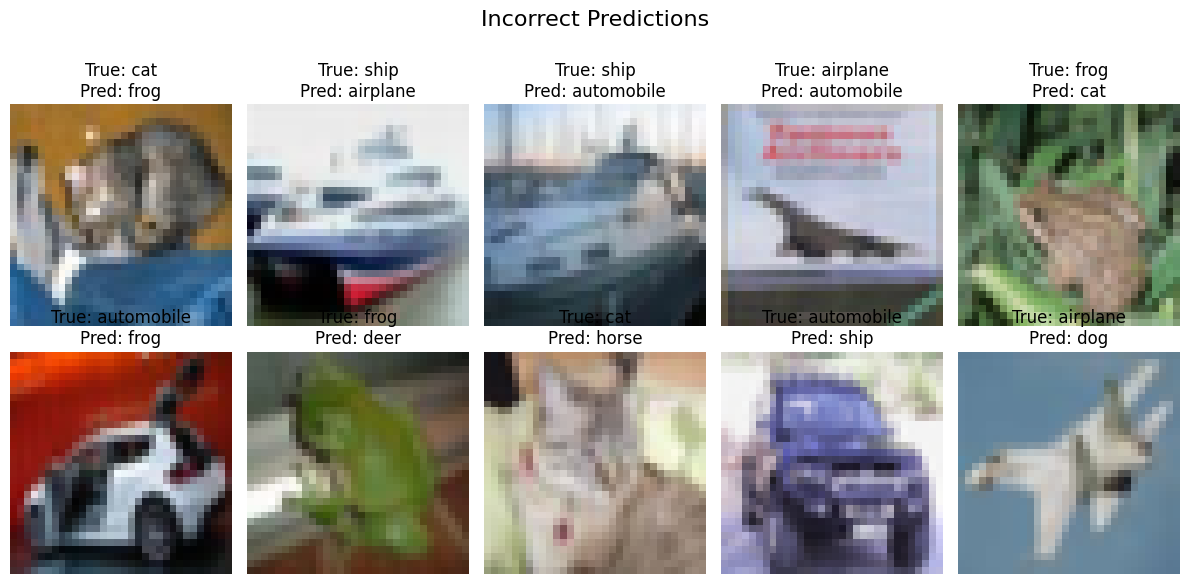

In [15]:
# Show some incorrect predictions
plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)
for i in range(min(10, len(incorrect))):
    plt.subplot(2, 5, i+1)
    idx = incorrect[i]
    plt.imshow(X_test_sample[idx])
    plt.title(f"True: {class_names[y_test_sample[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



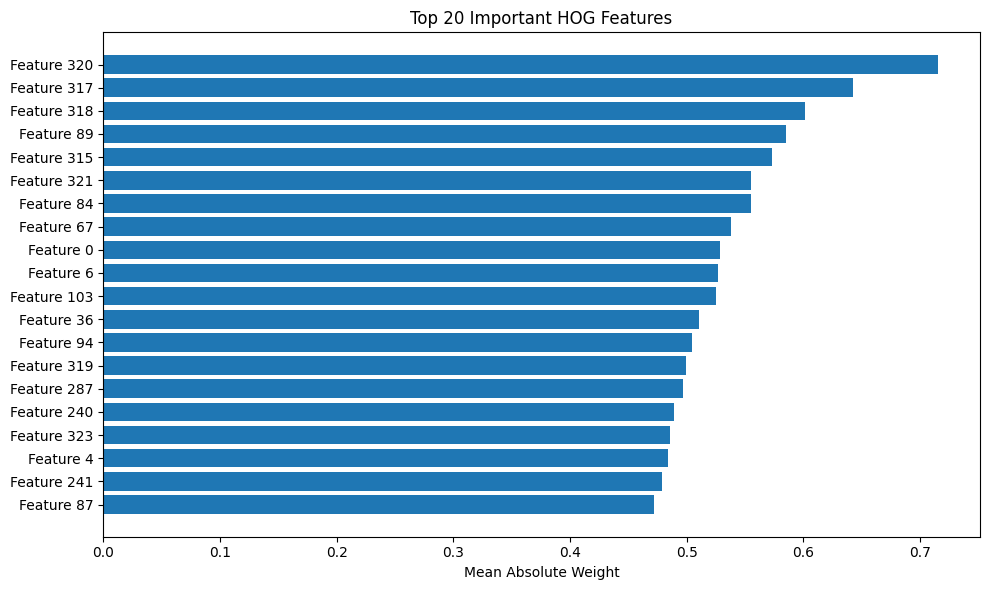

In [16]:
# Feature importance analysis
feature_importance = np.abs(svm.coef_).mean(axis=0)
top_indices = np.argsort(feature_importance)[-20:]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(20), feature_importance[top_indices])
plt.yticks(range(20), [f"Feature {i}" for i in top_indices])
plt.xlabel('Mean Absolute Weight')
plt.title('Top 20 Important HOG Features')
plt.tight_layout()
plt.show()